# Oregon Wildfires

### Import Data and Libraries

In [14]:
import datetime
from jdcal import jd2gcal
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

import cdsapi
import sklearn_pandas as skp
import altair as alt
from vega_datasets import data
from shapely.geometry import Point
import plotly.express as px
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
import folium
from folium.plugins import MarkerCluster


custom_colors = ['#68A33E', '#A10702', '#FB9E60', '#FFFF82', '#0F0326']

### Load in Raw Data

In [15]:
input_filename = 'FPA_FOD_20170508.sqlite'
conn = sqlite3.connect(input_filename)
query = '''
    SELECT
       *
    FROM
        Fires;
'''
df_raw = pd.read_sql_query(query, conn)

### Clean Data and Extract Oregon Boundaries

In [16]:
drop_columns = ['NWCG_REPORTING_AGENCY',
                'NWCG_REPORTING_UNIT_ID',
                'NWCG_REPORTING_UNIT_NAME',
                'FIRE_NAME',
                'COMPLEX_NAME', 
                'OWNER_DESCR',
                'OWNER_CODE']
df_US= df_raw.drop(columns= drop_columns)
df_US['MONTH'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[1])
df_US['DAY'] = df_US['DISCOVERY_DATE'].apply(lambda x: jd2gcal(x, 0)[2])

In [17]:
geometry = [Point(xy) for xy in zip(df_US['LONGITUDE'], df_US['LATITUDE'])]
df_geo = gpd.GeoDataFrame(df_US, geometry=geometry)
df_geo.crs = "EPSG:4326"

In [18]:
states = alt.topo_feature(data.us_10m.url, feature='states')
us_states = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
oregon = us_states[us_states['NAME'] == 'Oregon']
df_OR = df_geo[df_geo.STATE == 'OR']
df_OR.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,MONTH,DAY,geometry
31,32,32,FS-1418907,FED,FS-FIRESTAT,0601,Deschutes National Forest,1,1-001,BJ9H,None,None,None,None,2005,2453406.5,36,0943,4.0,Campfire,2453407.5,37.0,1226,0.1,A,43.995556,-121.414167,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x90\xaf\xeb\xb4\x81...,2,5,POINT (-121.41417 43.99556)
35,36,36,FS-1418916,FED,FS-FIRESTAT,0601,Deschutes National Forest,3,1-003,BK2W,None,None,None,None,2005,2453434.5,64,1042,4.0,Campfire,2453434.5,64.0,1107,0.1,A,44.043333,-121.386111,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x9c\x84_\x0b\xb6X^\...,3,5,POINT (-121.38611 44.04333)
43,44,44,FS-1418924,FED,FS-FIRESTAT,0601,Deschutes National Forest,6,1-004,BMP6,None,None,None,None,2005,2453465.5,95,1205,4.0,Campfire,2453465.5,95.0,1210,0.1,A,43.955556,-121.352222,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xc4\xf4\x10\xcf\x8a...,4,5,POINT (-121.35222 43.95556)
46,47,47,FS-1418935,FED,FS-FIRESTAT,0614,Umatilla National Forest,1,019,BE07,None,None,None,None,2005,2453440.5,70,1000,9.0,Miscellaneous,2453440.5,70.0,1401,5.0,B,44.911111,-119.696111,OR,69,069,Wheeler,b'\x00\x01\xad\x10\x00\x00@\xf5\x9c\x15\x8d\xe...,3,11,POINT (-119.69611 44.91111)
48,49,49,FS-1418943,FED,FS-FIRESTAT,0601,Deschutes National Forest,2,1-002,BKG2,None,None,None,None,2005,2453417.5,47,1535,4.0,Campfire,2453417.5,47.0,1600,0.1,A,43.725278,-121.574167,OR,17,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\x98\x86\x8f%\xbfd^\...,2,16,POINT (-121.57417 43.72528)


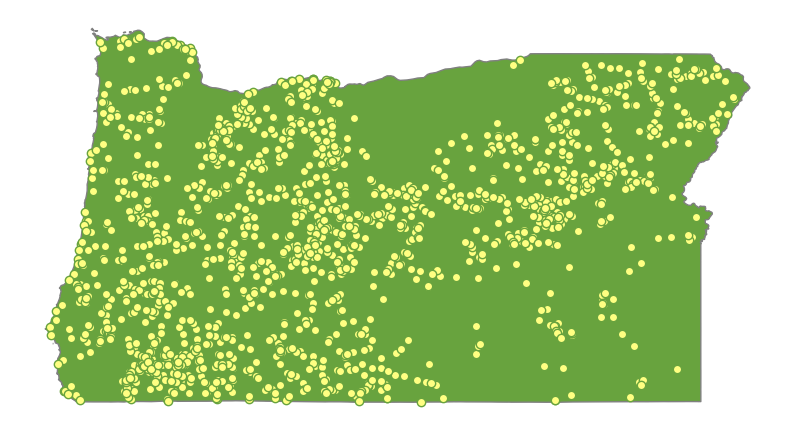

Row
    [0] Select(options=[2005, 2006, 2007, ...], value=2005)
    [1] ParamFunction(function, _pane=Str, defer_load=False)

In [28]:
import matplotlib.pyplot as plt
import panel as pn
from ipywidgets import widgets
pn.extension()

years = df_OR['FIRE_YEAR'].unique().tolist()  # Convert to a list

year_dropdown = pn.widgets.Select(options=years, name='Select Year')

def update_map(selected_year):
    df_selected_year = df_OR[df_OR['FIRE_YEAR'] == selected_year]
    
    fig, ax = plt.subplots(figsize=(10, 10))

    oregon.plot(ax=plt.gca(), color='#68A33E', edgecolor='grey')
    df_selected_year.plot(ax=ax, facecolor="#FFFF82", edgecolor="#68A33E")

    # Format
    ax.set_axis_off()
    ax.set_aspect("equal")  # This forces an equal aspect ratio

    plt.show()

@pn.depends(selected_year=year_dropdown)
def update(selected_year):
    update_map(selected_year)

# Create the Panel app
dashboard = pn.Row(year_dropdown, update)

# Display the Panel app
dashboard.servable()

### Oregon Wildfires by Year
When discussing wildfires in the US, California is usually front and center of the narrative. However, many other states that experience similar rates of burning, yet are often left off the table. We’d like to change that narrative, focusing on Oregon’s recent wildfire trends.  To complete this study, we have chosen to dig into observations taken between 2014-15. 

The map above highlights point data for observed wildfires across this span of time. To explore the data, use the toggle on the top to select a year. It is observed that, while wildfires occur in nearly every area of the state, they tend to be concentrated to the west, where a majority of the forests and heavily-forested areas are. However, in order to get better at preventing wildfires, it’s important to understand what factors may most contribute to their ignition. The following exploratory analyses use data that may contribute to predicting fires.

To obtain information about Oregon’s climate, we used the ‘riem’ package (available in R) to pull data from the Automated Surface Observing Systems (ASOS). Originally collected and stored by the National Weather Service, the ‘riem’ package is maintained by the Iowa Environmental Mesonet (IEM). We collected data related to dew point temperature, precipitation, and wind speed - all variables potentially related to wildfire activity. Our findings from these exploratory analyses are detailed below.

### Tracking Wildfires Across the Year

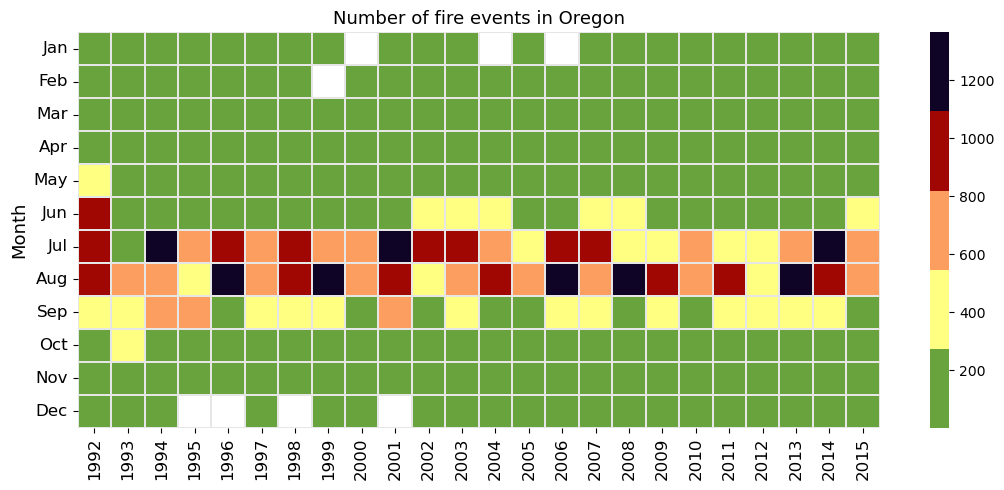

In [19]:
custom_colors = ['#68A33E','#FFFF82','#FB9E60','#A10702', '#0F0326']  # Add your desired hex colors

df_freq_mon = df_OR.groupby(['MONTH', 'FIRE_YEAR']).size().unstack()
df_freq_mon.to_csv("wildfireData.csv")
counter_fig = 1
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.2, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title('Number of fire events in Oregon', fontsize=13)
plt.tight_layout()

First, we observe the raw number of wildfires that occur in Oregon. There is a clear pattern of the summer months, July and August, being the most common months for wildfire season. This is a break in the pattern seen across the US, where wildfres occur throughout most times of the year. This can lead us to thinking that the causes of wildfires in Oregon may hold different factors than those seen in other areas of the country.

### Cause of Wildfires by Time of Year

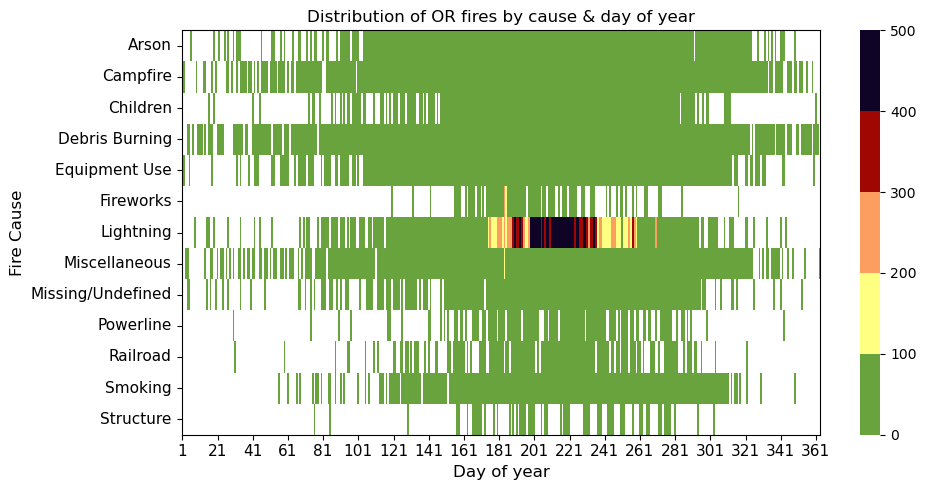

In [20]:
# plot fire frequency by cause and day of year
cause_by_doy = df_OR.groupby(['STAT_CAUSE_DESCR','DISCOVERY_DOY']).size().unstack()
counter_fig +=1
plt.figure(figsize=[10,5])
ax = sns.heatmap(cause_by_doy,cmap=custom_colors,vmin=0,vmax=500) #'CMRmap_r' <- old color scheme
plt.xticks(np.arange(0.5,366.5,20), labels=range(1,366,20), rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Fire Cause', fontsize=12)
plt.xlabel('Day of year', fontsize=12)
for borders in ["top","right","left","bottom"]:
    ax.spines[borders].set_visible(True)
plt.title('Distribution of OR fires by cause & day of year')
plt.tight_layout()

The above visualization describes trends in causes of wildfires in Oregon between 2014 and 2015.  Overall, lightning appears to be a main contributor, majorly happening in the summer months. Other factors often play a part, though are less sustained over time. One example lies in the sharp and unsustained uptick in fires caused by fireworks that happen in the middle of the year, presumably the 4th of July celebrations. However, there are a few causes which appear to happen equally across the year, regardless of season - these include burning debris and campfires.

## Download and Extract Climate Data

In [21]:
bendWeather = pd.read_csv("BendWeather.csv")

def convert_date(date_str):
    formats_to_try = ['%d/%m/%Y %H:%M:%S', '%m/%d/%Y %H:%M:%S']  # Add more formats if needed
    for fmt in formats_to_try:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            pass
    return None
bendWeather['interval60'] = pd.to_datetime(bendWeather['interval60'], format='%m/%d/%Y %H:%M')
bendWeather['Day'] = bendWeather['interval60'].dt.day
bendWeather['Month'] = bendWeather['interval60'].dt.month
bendWeather['Year'] = bendWeather['interval60'].dt.year
bendWeather['Hour'] = bendWeather['interval60'].dt.hour

bendWeather.head(2)

,interval60,Temperature,Precipitation,Wind_Speed,Dew_Point_Temp,Day,Month,Year,Hour
0,2020-01-01 00:00:00,46.4,0.02,15,41.0,1,1,2020,0
1,2020-01-01 01:00:00,44.6,0.01,14,41.0,1,1,2020,1


## Analyzing Weather Patterns
### Annual Temperature Trends

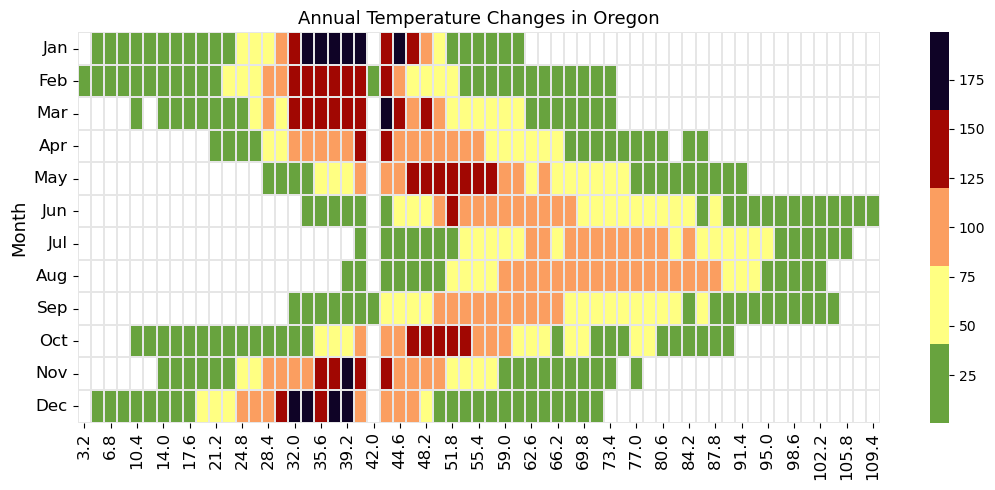

In [22]:
df_freq_mon = bendWeather.groupby(['Month', 'Temperature']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title('Annual Temperature Changes in Oregon', fontsize=13)
plt.tight_layout()

The visualization above shows average temperature variations between the years 2014-15. Oregon’s weather changes drastically among seasons, with warm weather seen most commonly in the dog days of summer of July and August. During this season, temperatures can reach up to almost 110 degrees Fahrenheit. During the colder months, between November and March, temperatures generally range between 32 and 42 degrees Fahrenheit.

### Patterns in Wind Speed

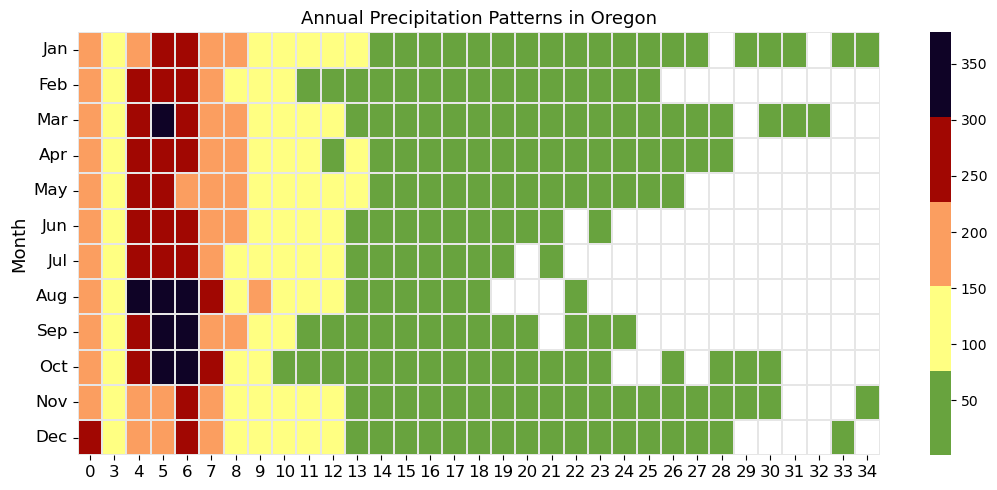

In [23]:
# Annual Patterns in Wind Speed
df_freq_mon = bendWeather.groupby(['Month', 'Wind_Speed']).size().unstack()
# plot monthly frequency of fire events
counter_fig = 3
mon_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=[11,5])
sns.heatmap(df_freq_mon, cmap=custom_colors, linewidth=.01, linecolor=[.9,.9,.9])
plt.yticks(np.arange(0.5,12.5), labels=mon_ticks, rotation=0, fontsize=12)
plt.xticks(fontsize=12);
plt.xlabel('')
plt.ylabel('Month', fontsize=13)
plt.title('Annual Precipitation Patterns in Oregon', fontsize=13)
plt.tight_layout()


The above visualization details average wind speeds my time of year for 2014-15.  While there is typically a light breeze in the air year-round, the cooler months of late fall and early winter occasionally see heavier gusts - October through January may see winds higher than 30 miles per hour. Now below, we will combine the the wildfires for 2014 and 2015 in oregon with the corresponding weather data for the to produce a dahsboard in the analysis tab. 

In [25]:
import pandas as pd
from astropy.time import Time
from datetime import datetime
import numpy as np
pd.set_option('display.max_columns', None)

year = [2014, 2015]
df_OR_year = df_OR[df_OR['FIRE_YEAR'].isin(year)]
pd.set_option('display.max_columns', None)

# Filter out non-finite values
df_OR_year = df_OR_year[np.isfinite(df_OR_year['DISCOVERY_DATE'])]

# Convert Julian dates to standard dates
df_OR_year['DISCOVERY_DATE'] = Time(df_OR_year['DISCOVERY_DATE'], format='jd').to_value('iso', subfmt='date')
df_OR_year.head(20)

##################################################

# Drop rows with NA values in the 'DISCOVERY_TIME' column
df_OR_year = df_OR_year.dropna(subset=['DISCOVERY_TIME'])

# Check the datatype of 'DISCOVERY_TIME'
if pd.api.types.is_datetime64_any_dtype(df_OR_year['DISCOVERY_TIME']):
    # Round off to the nearest hour
    df_OR_year['DISCOVERY_TIME'] = df_OR_year['DISCOVERY_TIME'].dt.round('H').dt.strftime('%H:%M:%S')
else:
    # Convert to datetime object
    df_OR_year['DISCOVERY_TIME'] = df_OR_year['DISCOVERY_TIME'].apply(lambda x: datetime.strptime(x, '%H%M'))
    # Round off to the nearest hour
    df_OR_year['DISCOVERY_TIME'] = df_OR_year['DISCOVERY_TIME'].dt.round('H').dt.strftime('%H:%M:%S')

    
################################################   

# Drop rows with NaN values in 'DISCOVERY_DATE' or 'DISCOVERY_TIME'
df_OR_year = df_OR_year.dropna(subset=['DISCOVERY_DATE', 'DISCOVERY_TIME'])

# Combine date and time into a new column
df_OR_year['DISCOVERY_DATETIME'] = pd.to_datetime(df_OR_year['DISCOVERY_DATE'] + ' ' + df_OR_year['DISCOVERY_TIME'], format='%Y-%m-%d %H:%M:%S')

###############################################

df_OR_year['DISCOVERY_DATETIME'] = df_OR_year['DISCOVERY_DATETIME'].dt.floor('H')

df_OR_year.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,MONTH,DAY,geometry,DISCOVERY_DATETIME
1722247,1722248,300000318,FS-1527910,FED,FS-FIRESTAT,0601,Deschutes National Forest,241,1-157,JGK4,None,None,None,None,2014,2014-11-10,314,10:00:00,9.0,Miscellaneous,2456971.5,314.0,1049,0.1,A,43.787778,-121.116667,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xb8\x0b{wwG^\xc0\xd...,11,10,POINT (-121.11667 43.78778),2014-11-10 10:00:00
1722248,1722249,300000319,FS-1527911,FED,FS-FIRESTAT,0601,Deschutes National Forest,242,1-158,JG4Y,None,None,None,None,2014,2014-12-15,349,11:00:00,9.0,Miscellaneous,2457006.5,349.0,1201,0.1,A,43.820000,-121.321667,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00<\xf7\xcc/\x96T^\xc0...,12,15,POINT (-121.32167 43.82000),2014-12-15 11:00:00
1722249,1722250,300000320,FS-1527906,FED,FS-FIRESTAT,0601,Deschutes National Forest,136,1-086,EK2A,None,None,None,None,2014,2014-07-29,210,18:00:00,1.0,Lightning,2456867.5,210.0,1935,0.1,A,43.397778,-121.218611,OR,Lake,037,Lake,b'\x00\x01\xad\x10\x00\x00\x80\xffs\xb9\xfdM^\...,7,29,POINT (-121.21861 43.39778),2014-07-29 18:00:00
1722250,1722251,300000321,FS-1527907,FED,FS-FIRESTAT,0601,Deschutes National Forest,232,1-149,JFC6,None,None,None,None,2014,2014-10-04,277,13:00:00,9.0,Miscellaneous,2456936.5,279.0,1749,17.0,C,43.652778,-120.971111,OR,Deschutes,017,Deschutes,b'\x00\x01\xad\x10\x00\x00\xdc\x8e6\xaf&>^\xc0...,10,4,POINT (-120.97111 43.65278),2014-10-04 13:00:00
1722251,1722252,300000322,FS-1525770,FED,FS-FIRESTAT,0601,Deschutes National Forest,007,1-007,H36G,None,None,None,None,2014,2014-07-05,186,11:00:00,4.0,Campfire,2456843.5,186.0,1322,0.1,A,43.485278,-121.121389,OR,Lake,037,Lake,b'\x00\x01\xad\x10\x00\x00t)\xe8\xd5\xc4G^\xc0...,7,5,POINT (-121.12139 43.48528),2014-07-05 11:00:00


In [26]:
import pandas as pd
bendWeather_up = pd.read_csv("BendWeather_up.csv")

bendWeather_up = bendWeather_up[bendWeather_up['interval60'].str.len() > 10]
bendWeather_up['interval60'] = pd.to_datetime(bendWeather_up['interval60'], 
                                              format='%Y-%m-%d %H:%M:%S'
                                             )
merged_df = pd.merge(df_OR_year, 
                     bendWeather_up, 
                     left_on='DISCOVERY_DATETIME', 
                     right_on='interval60', 
                     how='inner')